##  Feedforward Neural Networks in PyTorch 

In [ ]:
import torch
import torch.nn as nn # contain various NN layers
import torch.nn.functional as F # contains activation functions
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# check which device is available in order of the fast/most supported to the slowest
device = (
    "cuda" #  NVIDEA Cuda framework: most supported but maybe slower than mps if mps is available
    if torch.cuda.is_available() 
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [2]:
class FNN(torch.nn.Module):
    def __init__(self, hidden_sizes=[10], n_in = 1, n_out = 1,
                 activation = nn.ReLU()) -> None:
        super(FNN, self).__init__()
        """
        hidden_sizes: a list of containing the number of neurons in the hidden layers
        n_in: dimension of inputs
        n_out: dimension of output
        acitivation: activation function as a module. This should from the nn submodule of PyTorch
        
        """

        hidden_sizes = [n_in] + hidden_sizes 
        NN = [nn.Sequential( # nn.Sequential chains layers/modules one after the other
            nn.Linear(in_features=hidden_sizes[i], 
                      out_features=hidden_sizes[i+1]), activation)
            for i in range(len(hidden_sizes)-1)]
        NN += [nn.Linear(in_features=hidden_sizes[-1], out_features=n_out)]
        self.NN = nn.Sequential(*NN)
        
        #* single layer
        # W = nn.Linear(in_features=n_in, out_features=n_units, bias=True) 
        # Wout = nn.Linear(in_features=n_units, out_features=n_out, bias=False)
        # self.NN = nn.Sequential(
        #     W, # -> feeds the output to the next
        #     activation, # >--> takes input from previous and feeds the output to the next
        #     Wout  # >- takes input from previous
        # )
    def forward(self, X):
        return self.NN(X)

Suppose we are given noissy values of $y$ for the function $y = \cos(10\sqrt{2}x) + \sin(10\pi x)$ at different values of $x$, we want to be able to approximate the actual value of $y$. 

In [3]:
# unsqueeze extends the tensor with an extra dimension at dim e.g 2x3 matrix will become 2x1x3 with this syntax
X = torch.linspace(-1, 1, 500).unsqueeze(dim = 1) 
y_actual = torch.cos(10*np.sqrt(2)*X) + torch.sin(10*torch.pi*X)
# y_actual = X**2
y_noisy = y_actual + 0.1*torch.randn_like(y_actual)

#! create train-test split
n = X.size(0)
perm = torch.randperm(n)
n_train = int(0.8 * n)
train_idx, test_idx = perm[:n_train], perm[n_train:]
X_train = X[train_idx].to(device)
y_train = y_noisy[train_idx].to(device)

X_test = X[test_idx].to(device)
y_test = y_noisy[test_idx].to(device)


In [4]:

# initialise model, loss function and optimiser 
model = FNN(hidden_sizes=[10, 20, 5], activation=nn.Tanh()).to(device)

# the model should be stored in the device the data was in. 
model = model.to(device)

# loss function
loss_fn = nn.MSELoss()
# add parameters to an optimiser. Here, we are using Adam, SGD with momentum
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # lr is learning rate

# training cycle always gets the data or subsets of it 
optimizer.zero_grad() # always zero out gradient that maybe stored from previous iterations
y_pred_train = model(X_train)
train_loss = loss_fn(y_pred_train, y_train)
train_loss.backward()
optimizer.step() # update parameters 
# scheduler.step()

# Testing
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = loss_fn(y_pred_test, y_test)


print(f"Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

Train Loss: 1.2198 | Test Loss: 0.9482


In [5]:

# training cycle
n_epochs = 10000
print_every = 1000


train_losses = []
test_losses = []

for epoch in range(n_epochs):
    # Training
    optimizer.zero_grad() 
    y_pred_train = model(X_train)
    train_loss = loss_fn(y_pred_train, y_train)
    train_loss.backward()
    optimizer.step()
    # scheduler.step()
    
    # Testing
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
    
    
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")
    train_losses.append(train_loss.detach().item())
    test_losses.append(test_loss.detach().item())
    

Epoch 1000/10000 | Train Loss: 0.3771 | Test Loss: 0.3431
Epoch 2000/10000 | Train Loss: 0.3558 | Test Loss: 0.3278
Epoch 3000/10000 | Train Loss: 0.2197 | Test Loss: 0.2141
Epoch 4000/10000 | Train Loss: 0.2191 | Test Loss: 0.2137
Epoch 5000/10000 | Train Loss: 0.2169 | Test Loss: 0.2125
Epoch 6000/10000 | Train Loss: 0.0805 | Test Loss: 0.0880
Epoch 7000/10000 | Train Loss: 0.0773 | Test Loss: 0.0860
Epoch 8000/10000 | Train Loss: 0.0126 | Test Loss: 0.0158
Epoch 9000/10000 | Train Loss: 0.0130 | Test Loss: 0.0303
Epoch 10000/10000 | Train Loss: 0.0114 | Test Loss: 0.0151


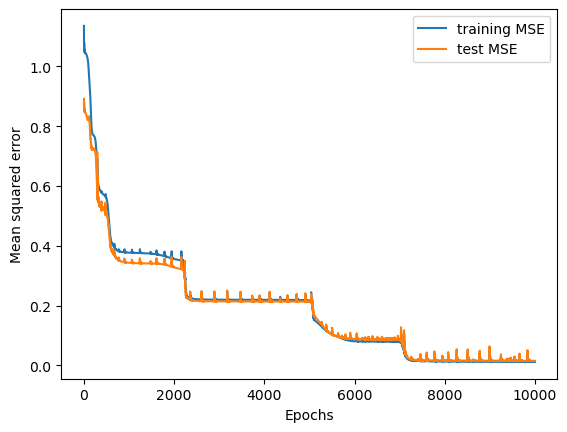

In [8]:

plt.plot(train_losses, label = 'training MSE')
plt.plot(test_losses, label = 'test MSE')
plt.xlabel("Epochs")
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

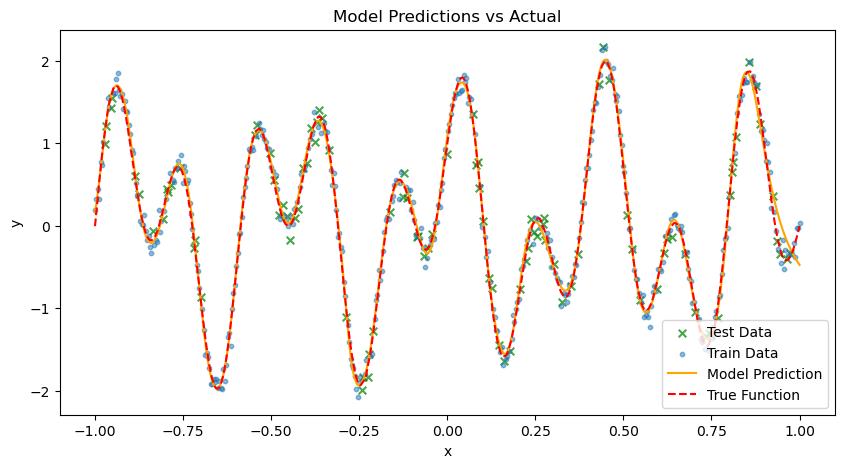

In [11]:


plt.figure(figsize=(10, 5))
with torch.no_grad():
    y_pred_test = model(X_test).to('cpu')
    y_pred_train = model(X_train).to('cpu')
    
    # Sort X_train and corresponding predictions for plotting
    sorted_indices = torch.argsort(X_train.flatten()).to('cpu')
    X_train_sorted = X_train[sorted_indices].to('cpu')
    y_train_sorted = y_train[sorted_indices].to('cpu')
    y_pred_train_sorted = y_pred_train[sorted_indices].to('cpu')
    # Prepare sorted test set for plotting
    sorted_indices_test = torch.argsort(X_test.flatten()).to('cpu')
    X_test_sorted = X_test[sorted_indices_test].to('cpu')
    y_test_sorted = y_test[sorted_indices_test].to('cpu')
    y_pred_test_sorted = y_pred_test[sorted_indices_test].to('cpu')

    # Plot test set as green 'x'
    plt.scatter(X_test_sorted.flatten(), y_test_sorted.flatten(), label='Test Data', alpha=0.7, s=30, color='green', marker='x')
    plt.scatter(X_train_sorted.flatten(), y_train_sorted.flatten(), label='Train Data', alpha=0.5, s=10)
    # Merge sorted X and predictions for smooth plotting
    X_all_sorted = torch.cat([X_train_sorted, X_test_sorted], dim=0)
    y_pred_all_sorted = torch.cat([y_pred_train_sorted, y_pred_test_sorted], dim=0)

    # Sort the merged X for a smooth line
    all_sorted_indices = torch.argsort(X_all_sorted.flatten())
    X_all_sorted = X_all_sorted[all_sorted_indices]
    y_pred_all_sorted = y_pred_all_sorted[all_sorted_indices]

    plt.plot(X_all_sorted.flatten(), y_pred_all_sorted.flatten(), color='orange', label='Model Prediction')
    plt.plot(X_train_sorted.flatten(), y_actual[train_idx][sorted_indices].flatten(), '--', color='red', label='True Function')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Model Predictions vs Actual')
    plt.show()

## Exercises


**1a. Try training the FNN with different activation functions.**

 The most popular choice of activation function is the `relu` and `tanh`. Other choices include `sigmoid` (`nn.Sigmoid()`), `softmax` (`nn.Softmax`) which are used when predicting probabilities, `elu` (`nn.ELU`), is a smoothen version of `relu`. This can be added as a parameter to initialiser of the `FNN` class. Also note that you may need to increase or decrease the learning rate. Because `relu` does not saturate i.e. its gradient does not tend to zero for large values, it tend to outperform other activation functions. You can use this [visualiser](https://datavizpyr.com/activation-functions-in-neural-networks/) to explore other choices of activation functions. There is usually some room in the choice of activation for the hidden layers. However, the output activtion function must be carefully chosen to suit the task. For example, using `relu` activation function for a task that outputs probabilities will probably lead to a poorly performing model.



**1b. Increasing the number of layers in the `FNN`**

The `FNN` trained on the quasiperiodic function above currently has only one layer. Increase the number of layers (depth) by adding more weight matrices before `Wout` and retrain. This can done by initialising the `FNN` class with `hidden_sizes` equal to the number of neurons in each layer. 


**1c. Use the Mean absolute error instead of mean squared error.**

The *mean absolute error* as the loss 
$$
L(\theta) = L(\theta) = \frac{1}{N}\sum_{i = 1}^N ||y_\text{pred}(X; \theta) - y_\text{actual} ||.
$$
It it implemented in `nn.L1Loss` in PyTorch. 